# Import Labreries

In [1]:
!pip install hazm

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

from hazm import Normalizer, Stemmer, word_tokenize, Lemmatizer, stopwords_list
from gensim.models import Word2Vec, FastText
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud

# Load Data

https://docs.google.com/spreadsheets/d/e/2PACX-1vSnexgSLBSbt9Udc-hgup46L0vg7Lok8pHcq4d-BXCi-F07r8WWBG701Oi3L_0ulQo8_YNwnbe_k38D/pub?gid=31503358&single=true&output=csv

https://docs.google.com/spreadsheets/d/1THwS9gy1e9LCoSIP08U8uYK5qdeX1tf-ioSf48uNACg/edit?usp=sharing

In [ ]:
!gdown --id '1HZ8HDQXnI_8A0wP9SnSwxTalEtv6ECM-'

In [9]:
df = pd.read_csv('/content/drive/MyDrive/Snappfood - Sentiment Analysis.csv')
df.head()

,Unnamed: 0,comment,label,label_id
0,NaN,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح,SAD,1
1,NaN,قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از مو...,HAPPY,0
2,NaN,قیمت این مدل اصلا با کیفیتش سازگاری نداره، فقط...,SAD,1
3,NaN,عالللی بود همه چه درست و به اندازه و کیفیت خوب...,HAPPY,0
4,NaN,شیرینی وانیلی فقط یک مدل بود.,HAPPY,0


In [10]:
df.shape

(70000, 4)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  1 non-null      object
 1   comment     70000 non-null  object
 2   label       70000 non-null  object
 3   label_id    70000 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 2.1+ MB


In [12]:
df.describe(include='all')

,Unnamed: 0,comment,label,label_id
count,1,70000,70000,70000.000000
unique,1,70000,2,NaN
top,:٣٠ ساعت طول کشید تا برسه!,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح,SAD,NaN
freq,1,1,35000,NaN
mean,NaN,NaN,NaN,0.500000
std,NaN,NaN,NaN,0.500004
min,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,0.500000
75%,NaN,NaN,NaN,1.000000


In [13]:
df.nunique()

Unnamed: 0        1
comment       70000
label             2
label_id          2
dtype: int64

# Preprocessing

We ignore unnamed column and then we drop rows which contain nans

In [14]:
df = df[['comment' , 'label' , 'label_id']]
df.dropna(inplace=True)
df.head()

,comment,label,label_id
0,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح,SAD,1
1,قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از مو...,HAPPY,0
2,قیمت این مدل اصلا با کیفیتش سازگاری نداره، فقط...,SAD,1
3,عالللی بود همه چه درست و به اندازه و کیفیت خوب...,HAPPY,0
4,شیرینی وانیلی فقط یک مدل بود.,HAPPY,0


We check if there is a happy label with label_id = 1.0 because thats an exception and the equivalent id for happy is 0.0 and for sad is 1.0

In [15]:
df.query('label == "HAPPY" and label_id == 1.0')

,comment,label,label_id


In [16]:
df.query('label == "SAD" and label_id == 0')

,comment,label,label_id


label_id's type is converted to int

In [17]:
df['label_id'] = df['label_id'].astype(int)
df.head()

,comment,label,label_id
0,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح,SAD,1
1,قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از مو...,HAPPY,0
2,قیمت این مدل اصلا با کیفیتش سازگاری نداره، فقط...,SAD,1
3,عالللی بود همه چه درست و به اندازه و کیفیت خوب...,HAPPY,0
4,شیرینی وانیلی فقط یک مدل بود.,HAPPY,0


Split data into X and y

In [18]:
X = (df['comment'])
y = (df['label_id'])

X.shape

(70000,)

Remove all punctuation(in both English and Persian), and I also deleted english alphabet in order to have persian text and nothing else.

In [19]:
X = X.apply(lambda x: re.sub(r'[\da-zA-Z\!\(\)\-\[\]\{\}\;\:\'\"\\\,\<\>\.\/\?\@\#\$\%\^\&\*\_\~\؟\،\٪\×\÷\»\«]', '', x))

X.head()

0      واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح
1    قرار بود  ساعته برسه ولی نیم ساعت زودتر از موق...
2    قیمت این مدل اصلا با کیفیتش سازگاری نداره فقط ...
3    عالللی بود همه چه درست و به اندازه و کیفیت خوب...
4                         شیرینی وانیلی فقط یک مدل بود
Name: comment, dtype: object

Split data into train and test

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Use hazm library to make the data more understandable for the model. First we normalize X (both train and test)

In [21]:
normalizer = Normalizer()
X_train = X_train.apply(lambda x: normalizer.normalize(x))
X_test = X_test.apply(lambda x: normalizer.normalize(x))

X_train.head(10)

14153    خیلی خوشمزه بود ولی در ظرف دورچین باز شده بود ...
63084                        برنج زده جوجه‌کباب هم مثل سنگ
10480    واقعا خیلی خوشمزه بود خیلی بسته بندی هم خیلی ج...
23631    کیفیت غذا بسیار پایین بود سالاد بد مزه و همبرگ...
41038    واقعا این معجون جای تشکر و یه خسته نباشید از ت...
25819    شیرینی‌ها را بسیار بی‌سلیقه و درهم داخل جعبه گ...
2032     یک ساعت و ربع برای تحویل سفارش سوپرمارکتی اصلا...
29051    توی منو نمشوته گرم گوشت ولی چرخ کردست با پیازه...
8064                         قیمت نسبت به حجم واقعا بالاست
48812    کیفیت به شدت پایین غذا خیلی شور و بدمزه بود ما...
Name: comment, dtype: object

Use hazm's word tokenizer. As a resualt each word in a sentence was splitted and now in each row we have a list of words

In [22]:
X_train = X_train.apply(lambda x: word_tokenize(x))
X_test = X_test.apply(lambda x: word_tokenize(x))

X_test.head()

3325     [واقعا, عالی, بود, هم, تازه, هم, خوشمزه, از, ه...
15014    [خوب, بود, بسته, بندی, و, قیمت, خیلی, مناسب, بود]
20409    [عکس, شیرینی, خامه‌ای, متفاوت, بود, با, چیزی, ...
51452                      [عالی, میرزا, قاسمی, عالی, بود]
52891    [سیب‌زمینی, طعم, تلخی, می‌داد, و, مونده_بود, ن...
Name: comment, dtype: object

Hazm stemmer is now used to be applied on the words

In [23]:
stemmer = Stemmer()
X_train = X_train.apply(lambda words: [stemmer.stem(word) for word in words])
X_test = X_test.apply(lambda words: [stemmer.stem(word) for word in words])

X_test.head()

3325     [واقعا, عال, بود, ه, تازه, ه, خوشمزه, از, همه,...
15014       [خوب, بود, بسته, بند, و, قیم, خیل, مناسب, بود]
20409    [عکس, شیرین, خامه, متفاو, بود, با, چیز, که, فر...
51452                         [عال, میرزا, قاسم, عال, بود]
52891    [سیب‌زمین, طع, تلخ, می‌داد, و, مونده_بود, نوشا...
Name: comment, dtype: object

The roots of some word are found by utilizing hazm's lemmatizer

In [24]:
lemmatizer = Lemmatizer()
X_train = X_train.apply(lambda words: [lemmatizer.lemmatize(word) for word in words])
X_test = X_test.apply(lambda words: [lemmatizer.lemmatize(word) for word in words])

X_train.head()

14153    [خیل, خوشمزه, بود#باش, ول, در, ظرف, دورچین, با...
63084               [برنج, زده, جوجه‌کباب, #هست, مثل, سنگ]
10480    [واقعا, خیل, خوشمزه, بود#باش, خیل, بسته, بند, ...
23631    [کیف, غذا, بسیار, پایین, بود#باش, سالاد, بد, م...
41038    [واقعا, این, معجون, جا, تشکر, و, یه, خسته, بود...
Name: comment, dtype: object

At the last step of preprocessing the list of words in each row are now joined to become something like a sentence

In [25]:
X_train = X_train.apply(lambda x: ' '.join(x)).to_list()
X_test = X_test.apply(lambda x: ' '.join(x)).to_list()

# vectorizers

In [26]:
vectorizer = TfidfVectorizer()
x_train = vectorizer.fit_transform(X_train)
x_test = vectorizer.transform(X_test)

# Build & Evaluation Models

In [27]:
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.79      0.83      6958
           1       0.81      0.89      0.85      7042

    accuracy                           0.84     14000
   macro avg       0.84      0.84      0.84     14000
weighted avg       0.84      0.84      0.84     14000



In [28]:
xgb = XGBClassifier()
xgb.fit(x_train, y_train)
y_pred = xgb.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.78      0.83      6958
           1       0.80      0.90      0.85      7042

    accuracy                           0.84     14000
   macro avg       0.84      0.84      0.84     14000
weighted avg       0.84      0.84      0.84     14000



In [29]:
clf_pipeline = Pipeline([
    ('tfidf', vectorizer),
    ('xgb', xgb)
])

y_pred = clf_pipeline.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.78      0.83      6958
           1       0.80      0.90      0.85      7042

    accuracy                           0.84     14000
   macro avg       0.84      0.84      0.84     14000
weighted avg       0.84      0.84      0.84     14000



In [31]:
clf_pipeline.predict(['حیف پولییی که به این غذا دادم!!!'])

array([1])

In [32]:
mnb = MultinomialNB()
mnb.fit(x_train, y_train)
y_pred = mnb.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.76      0.81      6958
           1       0.79      0.89      0.84      7042

    accuracy                           0.82     14000
   macro avg       0.83      0.82      0.82     14000
weighted avg       0.83      0.82      0.82     14000



In [33]:
lr = LogisticRegression(max_iter=1000)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.81      0.84      6958
           1       0.82      0.89      0.85      7042

    accuracy                           0.85     14000
   macro avg       0.85      0.85      0.85     14000
weighted avg       0.85      0.85      0.85     14000



# Visualization

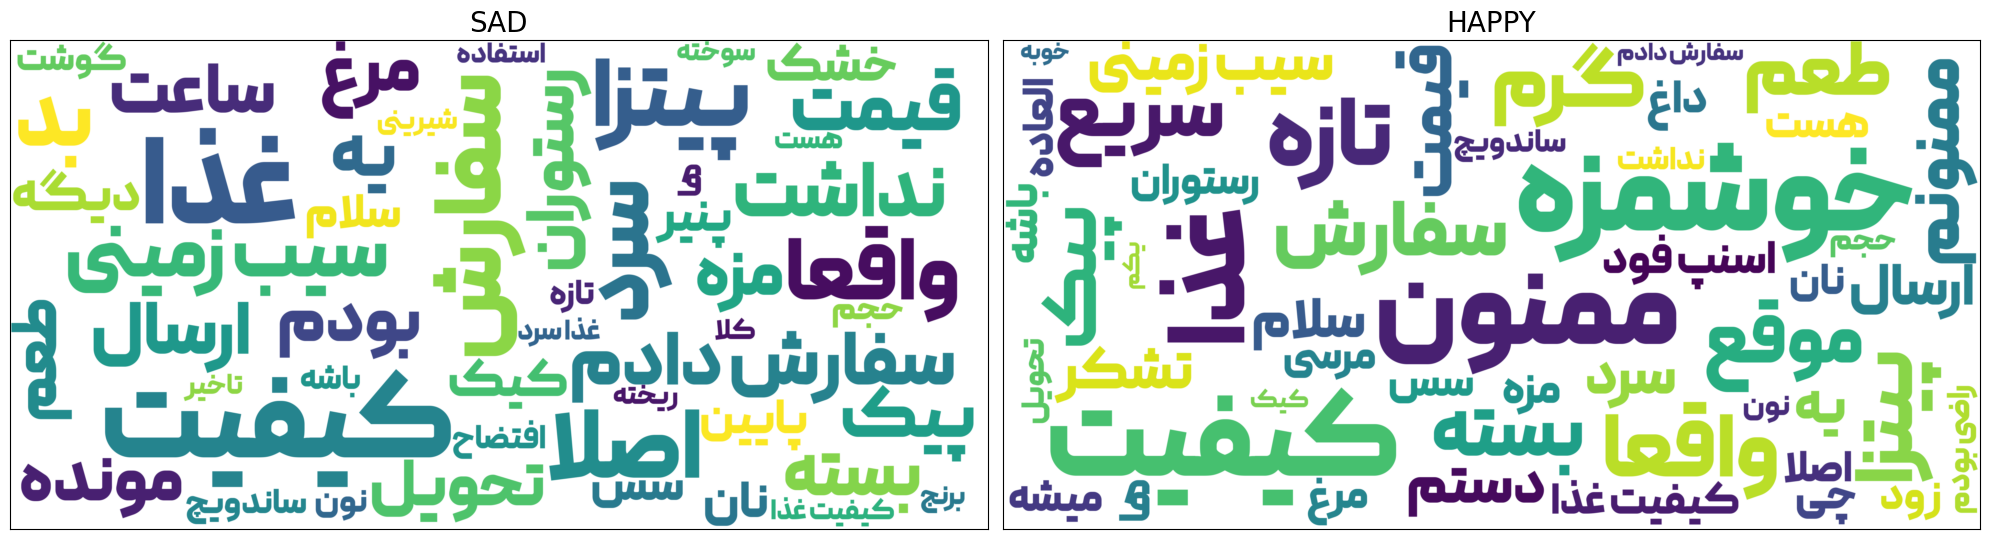

In [35]:
persian_stopwords = stopwords_list()

font_path = '/content/Peyda-Black.ttf'

plt.figure(figsize=(20, 10))

unique_sentiments = df['label'].unique()
num_unique_sentiments = len(unique_sentiments)
rows = num_unique_sentiments // 2 + num_unique_sentiments % 2
cols = 2 if num_unique_sentiments > 1 else 1

for index, label in enumerate(unique_sentiments):
    plt.subplot(rows, cols, index + 1)
    # Filter the dataframe by sentiment
    df_filtered = df[df['label'] == label]
    # Join all the text items in a single string
    text_data = " ".join(comment for comment in df_filtered['comment'])

    wordcloud = WordCloud(
        background_color='white',
        font_path=font_path,
        stopwords=persian_stopwords,
        width=800,
        height=400,
        max_words=50,
        max_font_size=100,
        scale=5
    ).generate(text_data)

    # Disable axis ticks
    plt.xticks([])
    plt.yticks([])
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(label, fontsize=20)

plt.tight_layout()
plt.show()

# Save the Trained Model

In [36]:
import pickle

with open('xgb.pkl', 'wb') as file:
    pickle.dump(xgb, file)

with open('vectorizer.pkl', 'wb') as file:
    pickle.dump(vectorizer, file)